In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
print("Pytorch Version: ",torch.__version__)
from torchvision import models
import time
from PIL import Image
import copy
import numpy as np
import os
import scipy.io as sio
import matplotlib.pyplot as plt

Pytorch Version:  1.2.0


In [2]:
batch_size = 30
use_cuda = torch.cuda.is_available()
# 本人使用cuda
device = torch.device("cuda" if use_cuda else "cpu")
image_dir = "./102flowers/jpg/"
label_file = "./imagelabels.mat"
# 分类的种类
num_classes = 102
# 本次训练的epochs,注意：训练是从0开始，经过反复的尝试，所以总的epochs远远大于本次的num_epochs
num_epochs =5
learning_rate=0.00003


## 加载数据 

In [3]:
file = os.listdir(image_dir)
length= len(file) # 获得样本总大小
index_list = np.random.permutation(length) # 获得打乱的下标
# 训练集：验证集：测试集=8:1:1
bound1 = int(length *0.8)
bound2 = int(length *0.9)
index_train_list= index_list[0:bound1]
index_val_list = index_list[bound1:bound2]
index_test_list = index_list[bound2:length]
index_all = {'train':index_train_list, 'val': index_val_list, 'test': index_test_list}

In [4]:
class MyDataset(Dataset):
    
    def __init__(self, data_dir, label_file, index_list, transform= None):
        super(MyDataset, self).__init__()
        self.file = os.listdir(data_dir)
        self.data_dir = data_dir
        self.transform = transform
        self.label_file = label_file
        self.index_list = index_list
        self.label_dict = sio.loadmat(self.label_file)
    
    def __len__(self):
        return len(self.index_list)
    
    def __getitem__(self, index):
        # 获取图片
        # index从0开始
        img_index=self.index_list[index]
        #img_index也是从0开始
        
        img_name = os.path.join(self.data_dir, self.file[img_index])
        image = Image.open(img_name)
        image = self.transform(image)
        #print(image.shape)
        
        # 获取标签
        label = self.label_dict['labels'][0][img_index] -1
        # 让 label 从0开始
        # 返回图片和标签
        return image, label
        
        

In [5]:
# 数据预处理
transform = {
    "train":transforms.Compose([
        transforms.RandomResizedCrop(224), #随机裁剪
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),# convert a PIL image to tensor (H*W*C) in range [0,255] to a torch.Tensor(C*H*W) in the range [0.0,1.0]
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    "val":transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    "test":transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
}

In [6]:
print("Initializing Datasets and Dataloaders...")
image_datasets = {x: MyDataset(data_dir=image_dir, label_file= label_file, 
                             index_list=index_all[x], transform= transform[x] ) for x in ['train', 'val', 'test']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val', 'test']}

Initializing Datasets and Dataloaders...


In [7]:
inputs, labels=next(iter(dataloaders_dict["train"])) #一个batch
print(inputs.shape)
print(labels)

torch.Size([30, 3, 224, 224])
tensor([ 2, 65,  2, 55, 15, 22, 64, 88, 51, 28,  4, 36, 49, 75, 94, 59, 61, 76,
        11, 77, 99, 59, 72, 76, 40, 87, 21, 86, 69, 21], dtype=torch.int32)


In [8]:
print(inputs[0].shape)

torch.Size([3, 224, 224])


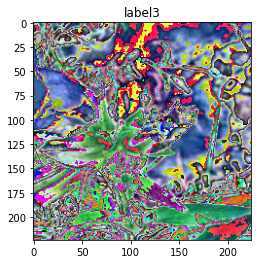

In [9]:
unloader = transforms.ToPILImage()  
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)     
    image = unloader(image) #tensor转换成图像
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(1) 
plt.figure()
imshow(inputs[0], title="label{}".format(labels[0]+1)) 

# 构建和训练resnet50

In [10]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [11]:
class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample= None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer=None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [12]:
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [13]:
class ResNet(nn.Module):

    def __init__(
        self,
        block,
        layers,
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation= None,
        norm_layer = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block, planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [14]:
def _resnet(
    block,
    layers,
    progress: bool,
    **kwargs
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    
    
    try :
        model=torch.load("model&weights_张文迪_2071350.pth")
    except BaseException:
        print("无预训练数据") 
    else:
        print("已加载预训练数据")
    return model

In [15]:
def resnet50(progress: bool = True, **kwargs) -> ResNet:
    return _resnet(Bottleneck, [3, 4, 6, 3], progress, **kwargs)

In [16]:
# 更新整个模型
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = True #更新整个模型

In [17]:
def initialize_model(num_classes):   
    model_ft = resnet50(num_classes=num_classes) 
    set_parameter_requires_grad(model_ft)
    input_size = 224 
        
    return model_ft, input_size
model_ft, input_size = initialize_model(num_classes)

已加载预训练数据


In [18]:
# 打印模型结构
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
# 打印需要更新的参数
for name,param in model_ft.named_parameters():
    print(name) 

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [20]:
model_ft = model_ft.to(device)        
params_to_update = model_ft.parameters() #需要更新的参数            
optimizer_ft = optim.SGD(params_to_update, lr=learning_rate, momentum=0.9) #定义优化器
# Setup the loss fxn
criterion = nn.CrossEntropyLoss() #定义损失函数

In [21]:
# 定义训练过程
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    since = time.time()
    val_acc_history = []
    val_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print("-"*10)
        
        for phase in ["train", "val"]:
            running_loss = 0.
            running_corrects = 0.
            if phase == "train":
                model.train()
            else: 
                model.eval()
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device=device,dtype=torch.int64)
                
                with torch.autograd.set_grad_enabled(phase=="train"):
                    outputs = model(inputs)
                    #print("outputs: {} labels: {}".format( outputs ,labels))
                    loss = criterion(outputs, labels)
                    
                _, preds = torch.max(outputs, 1)
                #返回每一行最大的数和索引，prds的位置是索引的位置
                if phase == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0) #交叉熵损失函数是平均过的
                running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
       
            print("{} Loss: {} Acc: {}".format(phase, epoch_loss, epoch_acc))
            if phase == "val" and epoch_acc > best_acc and len(dataloaders[phase].dataset) >15:  #>15是确保最后一组不是太小
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict()) #记录最好的模型参数
                
            if phase == "val":
                val_acc_history.append(best_acc) #记录每个epoch验证集的准确率
                val_loss_history.append(best_loss) #记录每个epoch验证集的准确率
            
        
    
    time_elapsed = time.time() - since
    print("Training compete in {}m {}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {}".format(best_acc))
    
    model.load_state_dict(best_model_wts) #把最新的参数复制到model中
    return model, val_acc_history, val_loss_history

In [22]:
model_ft, acc_history,  loss_history= train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 1/5
----------
train Loss: 0.692071526842324 Acc: 0.804304686307434
val Loss: 0.8284619456027453 Acc: 0.8937728937728938
Epoch 2/5
----------
train Loss: 0.7099807409271359 Acc: 0.7988093420851778
val Loss: 0.9055982396934495 Acc: 0.8937728937728938
Epoch 3/5
----------
train Loss: 0.7090169239264374 Acc: 0.8023202564493971
val Loss: 0.9888644724975139 Acc: 0.8974358974358975
Epoch 4/5
----------
train Loss: 0.697173594827962 Acc: 0.8044573347580523
val Loss: 1.9477951501533661 Acc: 0.8815628815628815
Epoch 5/5
----------
train Loss: 0.6947242290377525 Acc: 0.8110212181346359
val Loss: 1.6782622979237483 Acc: 0.894993894993895
Training compete in 26.0m 4.607954740524292s
Best val Acc: 0.8974358974358975


In [23]:
save_model = True
if (save_model):
    torch.save (model_ft, "model&weights_张文迪_2071350.pth")

E:\anaconda\software\envs\pytorch\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
E:\anaconda\software\envs\pytorch\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Bottleneck. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# 测试训练好的网络

In [24]:
# 定义训练过程
def test_network(model, dataloaders):
    running_loss = 0.
    running_corrects = 0.      
    model.eval()
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)
        labels = labels.to(device=device,dtype=torch.int64)
                
        with torch.autograd.set_grad_enabled(False):
            outputs = model(inputs)   
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()
            
            
    acc = running_corrects / len(dataloaders["test"].dataset)
       
    print("Testing Accutacy: {}".format(acc))

In [25]:
test_network(model_ft, dataloaders_dict)

Testing Accutacy: 0.8852258852258852


# 输出Loss & accuracy curve

In [26]:
acc_name = 'acc_history.mat'
loss_name = 'loss_history.mat'
total_num_epochs=0

def concate_history(file,key,curr_list,num_epochs):
    try:
        pre_history_mat = sio.loadmat(file)
    except BaseException:
        sio.savemat(file, {key:curr_list})
        total_num_epochs = num_epochs
        all_data = curr_list
    else:
        pre_history = pre_history_mat[key][0]
        all_data = np.concatenate((pre_history, curr_list))

        sio.savemat(file, {key:all_data})
        total_num_epochs = len(all_data)
        
    return all_data,total_num_epochs
    
all_acc_history, total_num_epochs= concate_history('acc_history.mat', 'acc',acc_history,num_epochs)
all_loss_history, total_num_epochs =concate_history('loss_history.mat', 'loss',loss_history,num_epochs)

输出精确曲线和代价曲线


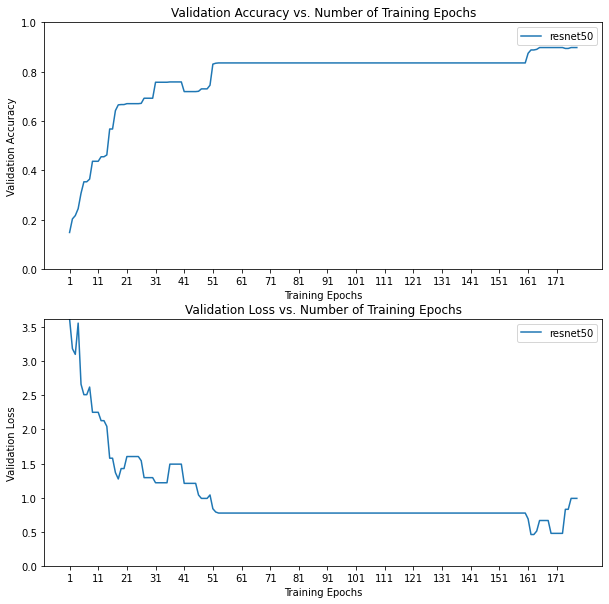

In [27]:
print("输出精确曲线和代价曲线")
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,total_num_epochs+1),all_acc_history,label="resnet50")
plt.ylim((0,1.))
plt.xticks(np.arange(1, total_num_epochs+1, 10.0))
plt.legend()

plt.subplot(2,1,2)
plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(1,total_num_epochs+1),all_loss_history,label="resnet50")
plt.ylim((0,max(all_loss_history)))
plt.xticks(np.arange(1, total_num_epochs+1, 10.0))
plt.legend()
plt.show()

# 可视化观察准确性

In [28]:
def visual_get_predict(image):
    tensor_image = transform['val'](image)
    tensor = torch.unsqueeze(tensor_image, dim=0)
    inputs = tensor.to(device)
    with torch.autograd.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1) # 返回最大值和下标
    
    return  preds.item()+1

输出9张图片作为参考


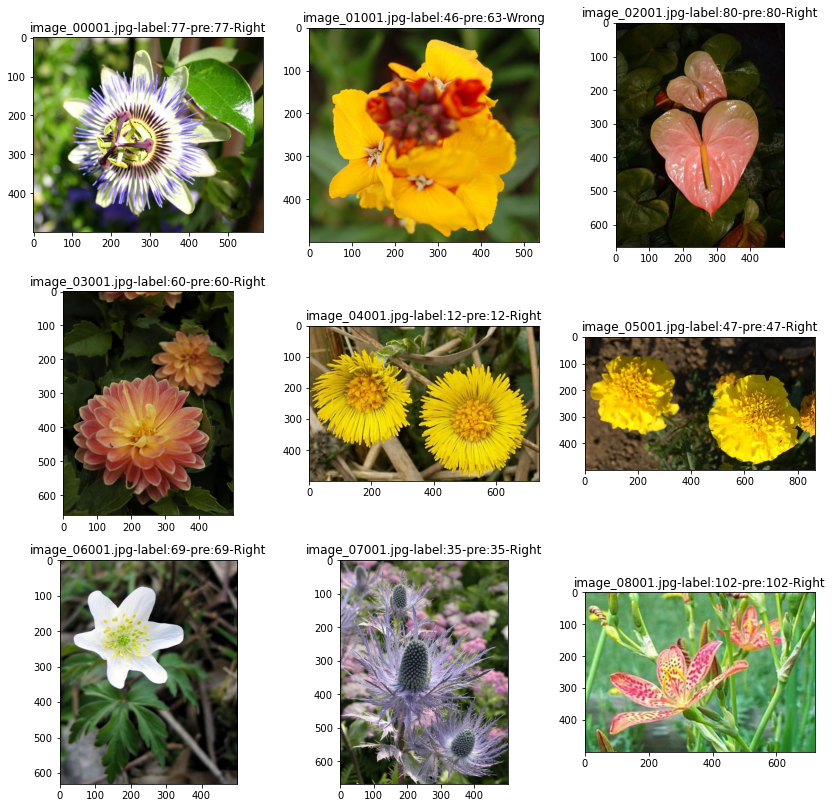

In [29]:
print("输出9张图片作为参考")
files = os.listdir(image_dir)
random_index=[0,1000,2000,3000,4000,5000,6000,7000,8000]

plt.figure(figsize=(14,14))
for i in range(0,9):
    img_name = os.path.join(image_dir, files[random_index[i]])
    #print(img_name)
    image = Image.open(img_name)# 获取图像
    label_dict = sio.loadmat(label_file)
    #print(i)
    label = label_dict['labels'][0][random_index[i]] # 获取标签
    #print(label)
    plt.subplot(3,3,i+1)
    pre_label= visual_get_predict(image) #获得预测标签
    #print(pre_label)
    plt.title("{}-label:{}-pre:{}-{}".format(files[random_index[i]],label,pre_label,"Right" if label==pre_label else "Wrong"))
    plt.imshow(image)
plt.show()